In [5]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [12]:
from tqdm.auto import tqdm

model = RecurrentGCN(node_features = 4).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        snapshot.cuda()
        y_hat = model(snapshot.x.cuda(), snapshot.edge_index.cuda(), snapshot.edge_attr.cuda())
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/200 [00:00<?, ?it/s]

In [53]:
import torch
from legacy.MovingMNIST import MovingMNIST

train_set = MovingMNIST(root='../../data/mnist', train=True, download=True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=100,
                 shuffle=True)

ModuleNotFoundError: No module named 'legacy'

In [29]:
train_set[0][0][0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [34]:
train_set

Dataset MovingMNIST
    Number of datapoints: 9000
    Train/test: train
    Root Location: ../../data/mnist
    Transforms (if any): None
    Target Transforms (if any): None

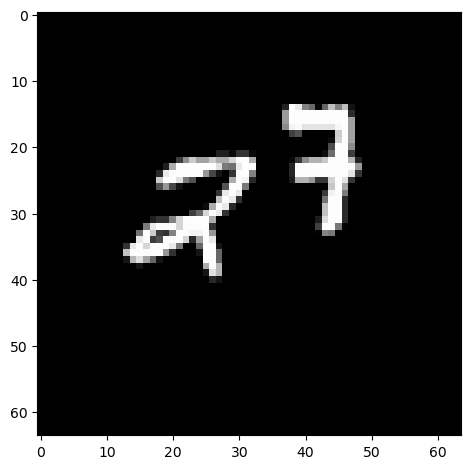

In [33]:
from skimage.io import *

imshow(train_set[0][0][9].numpy())

In [40]:

import torch
import torch.nn as nn
import os
import torch
root_dir = os.path.join(os.getcwd(), '.')
print(root_dir)

class Config:
    gpus = [0, ]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        num_workers = 8 * len(gpus)
        train_batch_size = 32
        valid_batch_size = 2 * train_batch_size
        test_batch_size = 2 * train_batch_size
    else:
        num_workers = 0
        train_batch_size = 2
        valid_batch_size = 2 * train_batch_size
        test_batch_size = 2 * train_batch_size
    data_file = 'datas/train-images-idx3-ubyte.gz'

    num_frames_input = 10
    num_frames_output = 10
    image_size = (28, 28)
    input_size = (64, 64)
    step_length = 0.1
    num_objects = [3]
    display = 10
    draw = 10
    train_dataset = (0, 10000)
    valid_dataset = (10000, 12000)
    test_dataset = (12000, 15000)
    epochs = 100

    # (type, activation, in_ch, out_ch, kernel_size, padding, stride)
    encoder = [('conv', 'leaky', 1, 32, 3, 1, 2),
             ('convlstm', '', 32, 32, 3, 1, 1),
             ('conv', 'leaky', 32, 64, 3, 1, 2),
             ('convlstm', '', 64, 64, 3, 1, 1),
             ('conv', 'leaky', 64, 128, 3, 1, 2),
             ('convlstm', '', 128, 128, 3, 1, 1)]
    decoder = [('deconv', 'leaky', 128, 64, 4, 1, 2),
               ('convlstm', '', 128, 64, 3, 1, 1),
               ('deconv', 'leaky', 64, 32, 4, 1, 2),
               ('convlstm', '', 64, 32, 3, 1, 1),
               ('deconv', 'leaky', 32, 32, 4, 1, 2),
               ('convlstm', '', 33, 32, 3, 1, 1),
               ('conv', 'sigmoid', 32, 1, 1, 0, 1)]

    data_dir = os.path.join(root_dir, 'data')
    output_dir = os.path.join(root_dir, 'output')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model_dir = os.path.join(output_dir, 'model')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    log_dir = os.path.join(output_dir, 'log')
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    cache_dir = os.path.join(output_dir, 'cache')
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

config = Config()

class ConvLSTMBlock(nn.Module):
    def __init__(self, in_channels, num_features, kernel_size=3, padding=1, stride=1):
        super().__init__()
        self.num_features = num_features
        self.conv = self._make_layer(in_channels+num_features, num_features*4,
                                       kernel_size, padding, stride)

    def _make_layer(self, in_channels, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels))

    def forward(self, inputs):
        '''
        :param inputs: (B, S, C, H, W)
        :param hidden_state: (hx: (B, S, C, H, W), cx: (B, S, C, H, W))
        :return:
        '''
        outputs = []
        B, S, C, H, W = inputs.shape
        hx = torch.zeros(B, self.num_features, H, W).to(inputs.device)
        cx = torch.zeros(B, self.num_features, H, W).to(inputs.device)
        for t in range(S):
            combined = torch.cat([inputs[:, t], # (B, C, H, W)
                                  hx], dim=1)
            gates = self.conv(combined)
            ingate, forgetgate, cellgate, outgate = torch.split(gates, self.num_features, dim=1)
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)
            outputs.append(hy)
            hx = hy
            cx = cy

        return torch.stack(outputs).permute(1, 0, 2, 3, 4).contiguous() # (S, B, C, H, W) -> (B, S, C, H, W)

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = []
        for idx, params in enumerate(config.encoder):
            setattr(self, params[0]+'_'+str(idx), self._make_layer(*params))
            self.layers.append(params[0]+'_'+str(idx))

    def _make_layer(self, type, activation, in_ch, out_ch, kernel_size, padding, stride):
        layers = []
        if type == 'conv':
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
        elif type == 'convlstm':
            layers.append(ConvLSTMBlock(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride))
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        :param x: (B, S, C, H, W)
        :return:
        '''
        outputs = [x]
        for layer in self.layers:
            if 'conv_' in layer:
                B, S, C, H, W = x.shape
                x = x.view(B*S, C, H, W)
            x = getattr(self, layer)(x)
            if 'conv_' in layer: x = x.view(B, S, x.shape[1], x.shape[2], x.shape[3])
            if 'convlstm' in layer: outputs.append(x)
        return outputs

class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = []
        for idx, params in enumerate(config.decoder):
            setattr(self, params[0]+'_'+str(idx), self._make_layer(*params))
            self.layers.append(params[0]+'_'+str(idx))

    def _make_layer(self, type, activation, in_ch, out_ch, kernel_size, padding, stride):
        layers = []
        if type == 'conv':
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
            elif activation == 'sigmoid': layers.append(nn.Sigmoid())
        elif type == 'convlstm':
            layers.append(ConvLSTMBlock(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride))
        elif type == 'deconv':
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, encoder_outputs):
        '''
        :param x: (B, S, C, H, W)
        :return:
        '''
        idx = len(encoder_outputs)-1
        for layer in self.layers:
            if 'conv_' in layer or 'deconv_' in layer:
                x = encoder_outputs[idx]
                B, S, C, H, W = x.shape
                x = x.view(B*S, C, H, W)
                x = getattr(self, layer)(x)
                x = x.view(B, S, x.shape[1], x.shape[2], x.shape[3])
            elif 'convlstm' in layer:
                idx -= 1
                x = torch.cat([encoder_outputs[idx], x], dim=2)
                x = getattr(self, layer)(x)
                encoder_outputs[idx] = x
        return x

class ConvLSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model(train_set[0][0])

/home/hussain/me/projects/tactile/src/legacy/.


ValueError: not enough values to unpack (expected 5, got 3)

In [52]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


In [43]:
for i in train_loader:
    print(model(i[0]))

ValueError: not enough values to unpack (expected 5, got 4)

In [47]:
ConvLSTMBlock(1, 4)(train_set[0][0])

ValueError: not enough values to unpack (expected 5, got 3)

In [41]:
model

ConvLSTM(
  (encoder): Encoder(
    (conv_0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (convlstm_1): Sequential(
      (0): ConvLSTMBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (conv_2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (convlstm_3): Sequential(
      (0): ConvLSTMBlock(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3),